In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tqdm
import numpy as np
import os

In [ ]:
from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [ ]:
# 날짜, 시간, 시가, 고가, 저가, 종가, 거래량, 거래대금, 누적체결매도수량, 누적체결매수수량
def CsvToData2(data_type, deep_rate, minimum_rate,maximum_rate, profit_rate, loss_rate):
    file_path = '/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/{}'.format(data_type)

    break_points = list()
    labels = list()
    ret_data = list()

    for file_name in tqdm(os.listdir(file_path)):
        full_path = os.path.join(file_path, file_name)
        raw_df = pd.read_csv(full_path, encoding='euc-kr')
        transform1 = raw_df[raw_df['시간'] < 1000]
        transform2 = (transform1.groupby(by='날짜').count()['시간'] == 59)
        #transform1 = raw_df[raw_df['시간'] <= 930]
        #transform2 = (transform1.groupby(by='날짜').count()['시간'] == 30)
        filtered_date = transform2.index[transform2].values

        if len(filtered_date) == 0:
            continue
        #yesterday = filtered_date[0]
        for j, today in enumerate(filtered_date):
            if j == 0:
                continue
            yesterday = datetime.strptime(str(today), "%Y%m%d") - timedelta(days=1)
            yesterday = int(datetime.strftime(yesterday, "%Y%m%d"))
            while yesterday not in raw_df['날짜'].values:
                yesterday = datetime.strptime(str(yesterday), "%Y%m%d") - timedelta(days=1)
                yesterday = int(datetime.strftime(yesterday, "%Y%m%d"))

            today_df = raw_df[raw_df['날짜'] == today].iloc[:59, 2:]
            today_start_price = today_df['시가'].values.tolist()[0]
            yesterday_end_price = raw_df[raw_df['날짜'] == yesterday].iloc[-1, 5]
            cond2 = (today_start_price >= (yesterday_end_price*1.01)) and (today_start_price < (yesterday_end_price * 1.15))
            cond3 = (today_start_price > 1200)
            if cond2==0 or cond3 == 0:
              continue
            deep_point, break_point, label = 0, 0, 0
            for i in range(30):
                if today_start_price * (1 + maximum_rate) < today_df.iloc[i, 3]:
                    break
                if today_start_price * (1 - deep_rate) > today_df.iloc[i, 2]:
                    deep_point = i
                    break

            if deep_point != 0 :
                for i in range(deep_point, 30):
                    if today_start_price * (1 - minimum_rate) > today_df.iloc[i, 2]:
                        break
                    if today_df.iloc[i, 3] > today_start_price:
                        break_point = i
                        break

            if break_point != 0 :
                for i in range(break_point+1, 59):
                    if today_df.iloc[i, 2] < today_df.iloc[break_point,3] * (1 - loss_rate):
                        break
                    if today_df.iloc[i, 1] > today_df.iloc[break_point,3] * (1 + profit_rate):
                        label = 1
                        break
                
                yesterday_df = raw_df[raw_df['날짜'] == yesterday].iloc[:break_point, 2:]
                today_trade = today_df['거래량'][:break_point].mean()
                yesterday_trade = yesterday_df['거래량'].mean()
                cond1 = (today_trade > (yesterday_trade *1.8))

                if cond1:
                  break_points.append(break_point)
                  labels.append(label)
                  ret_data.append(today_df.values.tolist())
            #yesterday = today

    return break_points, labels, ret_data

In [ ]:
kosdaq1_bps, kosdaq1_lables, kosdaq1_data = CsvToData2('kosdaq', 0.005, 0.03,0.03, 0.01, 0.01)

In [ ]:
 np.array(kosdaq1_bps).shape, np.array(kosdaq1_lables).shape, np.array(kosdaq1_data).shape

((2074,), (2074,), (2074, 59, 8))

In [ ]:
kosdaq2_bps, kosdaq2_labels, kosdaq2_data = CsvToData2('kosdaq2', 0.005, 0.02,0.02, 0.015, 0.0075)

In [ ]:
np.array(kosdaq2_bps).shape, np.array(kosdaq2_labels).shape, np.array(kosdaq2_data).shape

((1285,), (1285,), (1285, 59, 8))

In [ ]:
kospi_bps, kospi_labels, kospi_data = CsvToData2('kospi', 0.005, 0.02,0.02, 0.01, 0.01)

In [ ]:
np.array(kospi_bps).shape, np.array(kospi_labels).shape, np.array(kospi_data).shape

((1172,), (1172,), (1172, 59, 8))

(array([278., 352., 238., 165.,  88.,  82.,  59.,  45.,  37.,  21.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

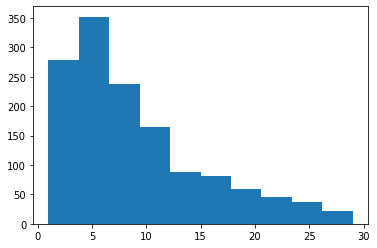

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(np.array(kosdaq1_bps))
#plt.plot(np.array(kosdaq1_data[0])[:,3])

In [ ]:
kosdaq_bps = np.concatenate((kosdaq1_bps, kosdaq2_bps), axis=0)
kosdaq_labels = np.concatenate((kosdaq1_lables, kosdaq2_labels), axis=0)
kosdaq_data = np.concatenate((kosdaq1_data, kosdaq2_data), axis=0)

In [ ]:
sum(np.array(kosdaq1_lables)==0),sum(np.array(kosdaq1_lables)==1)#,sum(np.array(kosdaq1_lables)==2)

(1089, 985)

In [ ]:
sum(np.array(kosdaq2_labels)==0),sum(np.array(kosdaq2_labels)==1)#,sum(np.array(kosdaq2_labels)==2)

(802, 483)

In [ ]:
sum(kosdaq1_lables) / kosdaq1_lables.__len__()#, sum(kosdaq2_labels) / kosdaq2_labels.__len__()

0.30563961485557084

In [ ]:
from sklearn.model_selection import train_test_split
whole_ind = np.arange(kosdaq_data.shape[0])
train_ind, val_ind, train_labels, val_labels = train_test_split(whole_ind, kosdaq_labels, test_size=0.1, random_state = 77)
train_ind, test_ind, train_labels, test_labels = train_test_split(train_ind, train_labels, test_size=0.1, random_state = 77)

In [ ]:
train = kosdaq_data[train_ind]
val = kosdaq_data[val_ind]
test = kosdaq_data[test_ind]

train_break_points = kosdaq_bps[train_ind]
val_break_points = kosdaq_bps[val_ind]
test_break_points = kosdaq_bps[test_ind]

In [ ]:
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_data_시초돌파.npy', train)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_data_시초돌파.npy', val)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_data_시초돌파.npy', test)

np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_labels_시초돌파.npy', train_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_labels_시초돌파.npy', val_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_labels_시초돌파.npy', test_labels)

np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_break_points_시초돌파.npy', train_break_points)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_break_points_시초돌파.npy', val_break_points)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_break_points_시초돌파.npy', test_break_points)